# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). If you use the Anaconda Python distribution, it is recommeded to install Tensorflow via the conda package manager: `conda install tensorflow-cpu`.

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

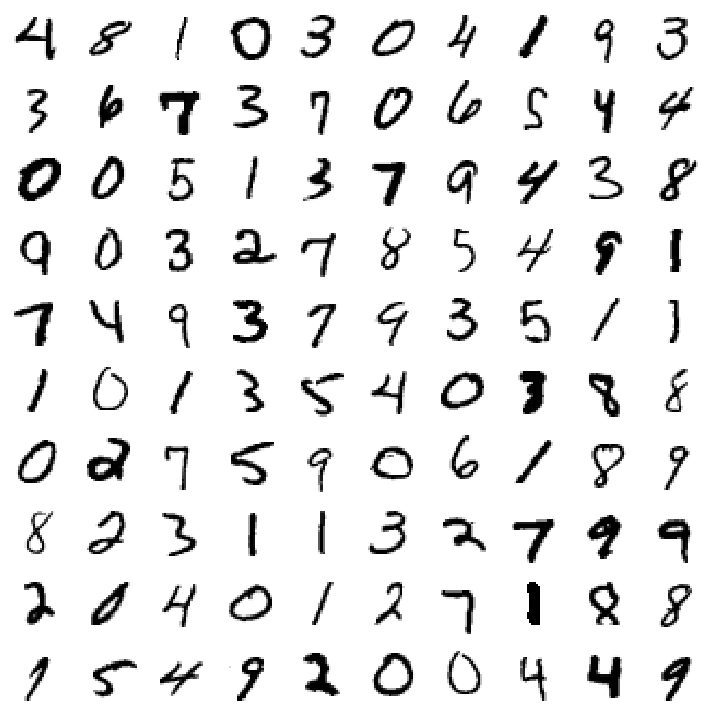

In [52]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train[np.random.randint(0, x_train.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [53]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_119 (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
__________

Compile and train the network (note that this could take a while).

In [54]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import pickle

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

# save checkpoints when model gets better val loss
filepath = "./trained-models/mnist_dense.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)

logs = model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[checkpoint])

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

# save training process
name = 'mnist_dense_losses'
with open('./trained-models/'+name, 'wb') as file_pi:
    pickle.dump(logs.history, file_pi)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 10s 163us/step - loss: 0.2440 - acc: 0.9264 - val_loss: 0.0579 - val_acc: 0.9819

Epoch 00001: val_loss improved from inf to 0.05789, saving model to ./trained-models/mnist_dense.h5
Epoch 2/12
60000/60000 [==============================] - 6s 105us/step - loss: 0.0864 - acc: 0.9745 - val_loss: 0.0437 - val_acc: 0.9855

Epoch 00002: val_loss improved from 0.05789 to 0.04368, saving model to ./trained-models/mnist_dense.h5
Epoch 3/12
60000/60000 [==============================] - 6s 104us/step - loss: 0.0641 - acc: 0.9809 - val_loss: 0.0352 - val_acc: 0.9894

Epoch 00003: val_loss improved from 0.04368 to 0.03517, saving model to ./trained-models/mnist_dense.h5
Epoch 4/12
60000/60000 [==============================] - 6s 104us/step - loss: 0.0522 - acc: 0.9837 - val_loss: 0.0332 - val_acc: 0.9897

Epoch 00004: val_loss improved from 0.03517 to 0.03321, saving model to ./trained-mod

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [55]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.028957381207613934
Test accuracy: 0.9917


## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. 

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

(20, 584, 565, 3)


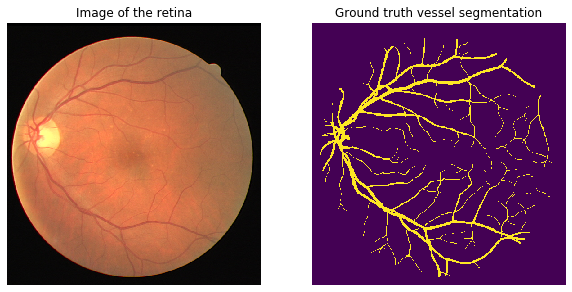

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [60]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
from code.unet_utils import load_data

# location of the DRIVE dataset
data_folder = './DRIVE/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# print the shape of image dataset
print(images.shape)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


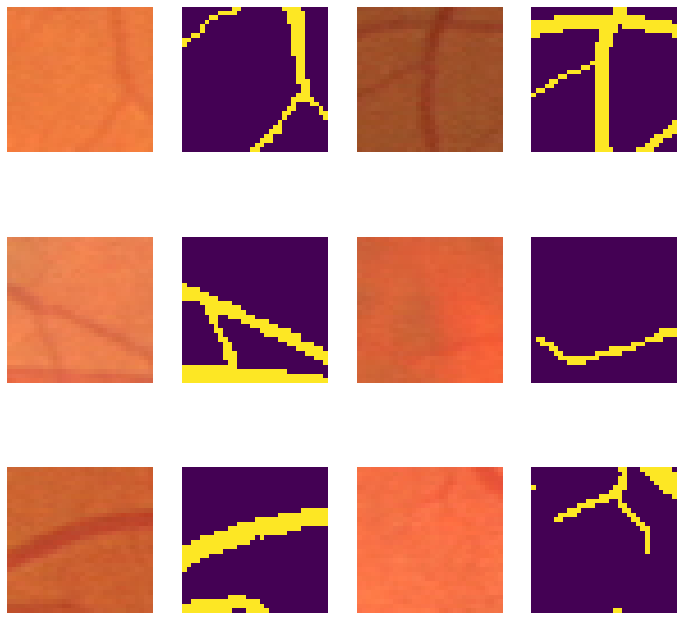

In [65]:
from code.unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [66]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [67]:
import os
from code.unet_model import unet
from code.unet_utils import datagenerator
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# save checkpoints when model gets better val loss
filepath = "./trained-models/retina_baseline.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping, checkpoint])

# Saving the model and loss / accuracies
name = 'retina_baseline_losses'
with open('./trained-models/'+name, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

(1, 584, 565, 3)
(1, 584, 565, 1)
Epoch 1/250
 - 10s - loss: 0.4926 - acc: 0.8497 - val_loss: 2.5377 - val_acc: 0.3778

Epoch 00001: val_loss improved from inf to 2.53774, saving model to ./trained-models/retina_baseline.h5
Epoch 2/250
 - 2s - loss: 0.3120 - acc: 0.9483 - val_loss: 3.0514 - val_acc: 0.4900

Epoch 00002: val_loss did not improve from 2.53774
Epoch 3/250
 - 2s - loss: 0.2170 - acc: 0.9581 - val_loss: 1.5621 - val_acc: 0.7245

Epoch 00003: val_loss improved from 2.53774 to 1.56209, saving model to ./trained-models/retina_baseline.h5
Epoch 4/250
 - 2s - loss: 0.1810 - acc: 0.9548 - val_loss: 8.6415 - val_acc: 0.1866

Epoch 00004: val_loss did not improve from 1.56209
Epoch 5/250
 - 2s - loss: 0.1745 - acc: 0.9516 - val_loss: 1.7115 - val_acc: 0.7981

Epoch 00005: val_loss did not improve from 1.56209
Epoch 6/250
 - 2s - loss: 0.2067 - acc: 0.9418 - val_loss: 2.7290 - val_acc: 0.6702

Epoch 00006: val_loss did not improve from 1.56209
Epoch 7/250
 - 2s - loss: 0.1518 - acc:

### Visualizing the segmentation results

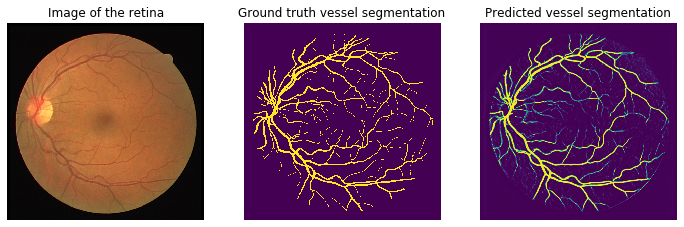

In [68]:
# run the model on one test image and show the results
from code.unet_utils import preprocessing
from keras.models import load_model

# model = load_model("./trained-models/retina_baseline.h5")

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

# Exercises

## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? 

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>

Number of parameters of a convolutional layer = (width of filter * height of filter * number of channels + 1) * number of filters.

Number of parameters of a fully-connected layer = (n+1) * m, where n is the number of neurons in the previous layer, m the number of neurons in the fully-connected layer. Every input neuron is connected to every output neuron and there is a bias for each output neuron. 

First conv layer<br>
-> input size 28 x 28 x 1 <br>
-> output size 26 x 26 x 32<br>
-> (3 * 3 * 1 + 1)* 32 = 320 parameters <br>

Second conv layer<br>
-> input size 26 x 26 x 32<br>
-> output size 24 x 24 x 64<br>
-> (3 * 3 * 32 + 1) * 64 = 18496 parameters <br>

Max pooling<br>
-> input size 24 x 24 x 64<br>
-> output size 12 x 12 x 64<br>

Flatten<br>
-> input size 12 x 12 x 64<br>
-> output size 9216<br>

First fully connected layer<br>
-> input size 9216<br>
-> output size 128<br>
-> (9216 + 1) * 128 = 1179776 parameters<br>

Last fully connected layer<br>
-> input size 128<br>
-> output size 10 <br>
-> (128 + 1) * 10 = 1290 parameters<br>

## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten

# load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

## fully convolutional model 
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (12, 12), activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(10, (1, 1), activation='softmax'))
model.add(Flatten())

#calculate nr of parameters
model.summary()

##compile and train the network 
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

filepath = "./trained-models/mnist_conv.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)

logs = model.fit(x_train, y_train, batch_size=128, epochs=12,
                 verbose=1, validation_data=(x_test, y_test),
                 callbacks=[checkpoint])

score = model.evaluate(x_test, y_test, verbose=0)

##look at test results
predictions = model.predict(x_test)
predicted_values = [np.argmax(x) for x in predictions]

print('Test loss:', score[0])
print('Test accuracy:', score[1])

# save training process losses
name = 'mnist_conv_losses'
with open('./trained-models/'+name, 'wb') as file_pi:
    pickle.dump(logs.history, file_pi)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_157 (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 1, 1, 128)         1179776   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 1, 1, 10)          1290      
__________

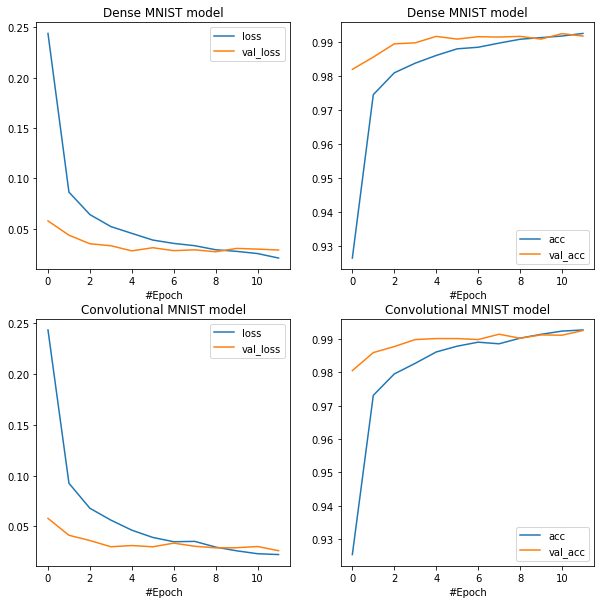

In [4]:
import pickle
import matplotlib.pyplot as plt

#Plot of losses and accuracy
logs = []
with open('./trained-models/mnist_dense_losses', 'rb') as f:
    logs.append(pickle.load(f))
    
with open('./trained-models/mnist_conv_losses', 'rb') as f:
    logs.append(pickle.load(f))
    
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax =  ax.flatten()
ax[0].plot(logs[0]['loss'])
ax[0].plot(logs[0]['val_loss'])
ax[0].legend(['loss', 'val_loss'])
ax[0].set_title("Dense MNIST model")
ax[0].set_xlabel("#Epoch")

ax[1].plot(logs[0]['acc'])
ax[1].plot(logs[0]['val_acc'])
ax[1].legend(['acc', 'val_acc'])
ax[1].set_title("Dense MNIST model")
ax[1].set_xlabel("#Epoch")

ax[2].plot(logs[1]['loss'])
ax[2].plot(logs[1]['val_loss'])
ax[2].legend(['loss', 'val_loss'])
ax[2].set_title("Convolutional MNIST model")
ax[2].set_xlabel("#Epoch")

ax[3].plot(logs[1]['acc'])
ax[3].plot(logs[1]['val_acc'])
ax[3].legend(['acc', 'val_acc'])
ax[3].set_title("Convolutional MNIST model")
ax[3].set_xlabel("#Epoch")

plt.show()

The first fully connected layer has an input of 9216 neurons (flattened 12 x 12 x 64 input/feature map) and an output of 128 neurons. Every input neuron is connected to every output neuron. The neurons in a convolutional layer are connected only to a local region of the input and many of the neurons share weights.

The fully connected layer can be converted to a convolutional layer. The kernel size will be equal to the size of the input (12 x 12) and the number of filters equal to number of output neurons of the FCL (128). The output size will then be (1 x 1 x) 128. 

The same is done for the second/last fully connected layer: the kernel size is set equal to the input size (1 x 1) and the number of filters is equal to number of output neurons of the FCL (10). The output size will then be equal to (1 x 1 x) 10. 

The two models have a similar test loss of 0.03 and a test accuracy of 0.99 (for the results of the original MNIST model see the preliminaries). Running the models multiple times gives slightly different results, because there is always some "randomness" in the models (e.g. the dropout layer), but the results are always in the same order of magnitude. This shows that the models have the same behaviour. 

Another way to prove that the models have the same behaviour is by looking at the training & validation losses and accuracy graphs (see figures above). These graphs show the same pattern/progress/behaviour.

## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>

In the contracting path, convolutions and pooling are applied to the images in every consecutive layer, resulting in downsampling and the loss of border pixels. The acquired feature maps can then be used to predict the desired class.<br>
In the expansive path, many border pixels and high resolution features have been lost, which is information that cannot be corrected for during upsampling.
This is counteracted by adding a (correctly cropped) version of (less downsampled, high resolution) images without the missing border pixels through the connections that skip part of the down- and upsampling process.<br>
The skip connections allow the network to retrieve the spatial information lost by pooling operations. 
With these skip connections, context information from the high resolution images can be combined with the upsampled output and is used for correct localisation of the predicted class.
This context information is stored in feature channels and propagate in the upsampling part, which can be used to predict the missing border pixels. <br>

It will be possible to train the model without the skip connections, but correct localisation of the predicted class is not achieved as the high resolution images are missing in the upsampling part. <br>
Also, border pixels cannot be correctly predicted/recovered because of this. <br>
However, classes can still be predicted correctly since it is handled by the downsampling part, which is unchanged.
Prediction errors will probably increase when class distinctive features are located near the image border, as these features might be lost in the upsampling part. <br>



## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>


Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above. 

Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


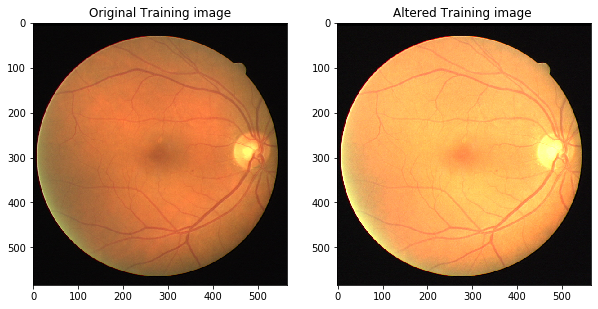

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle
from code.unet_utils import extract_patches, preprocessing, datagenerator, load_data
from code.unet_model import unet
from code.change_brightness import *
from code.gryds_function import *
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from glob import glob

data_folder = './DRIVE/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

#Create training images with an altered brightness
train_image_original=train_images[0]
Altered_brightness_images=change_brightness(train_images)
train_images=Altered_brightness_images
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)
# Visualize the results of the alteration of the training image brightness by comparing the first original training image
# before and after its alteration.

fig, ax = plt.subplots(1, 2,figsize=(10, 10))
ax[0].imshow(train_image_original)
ax[0].set_title("Original Training image")
ax[1].imshow(Altered_brightness_images[0])
ax[1].set_title("Altered Training image ")
plt.show()

In [4]:
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# saving checkpoints
filepath = "./trained-models/retina_random_brightness.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
                              callbacks=[early_stopping, checkpoint])

# Saving loss / accuracies
name = 'retina_random_brightness_losses'
with open('./trained-models/'+name, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/250
50/50 [==============================] - 7s 132ms/step - loss: 0.5122 - acc: 0.8452 - val_loss: 0.8456 - val_acc: 0.6852

Epoch 00001: val_loss improved from inf to 0.84562, saving model to ./trained-models/retina_random_brightness.h5
Epoch 2/250
50/50 [==============================] - 2s 44ms/step - loss: 0.3028 - acc: 0.9458 - val_loss: 0.2450 - val_acc: 0.9244

Epoch 00002: val_loss improved from 0.84562 to 0.24503, saving model to ./trained-models/retina_random_brightness.h5
Epoch 3/250
50/50 [==============================] - 2s 47ms/step - loss: 0.2091 - acc: 0.9551 - val_loss: 0.7854 - val_acc: 0.8763

Epoch 00003: val_loss did not improve from 0.24503
Epoch 4/250
50/50 [==============================] - 2s 45ms/step - loss: 0.1637 - acc: 0.9599 - val_loss: 0.2837 - val_acc: 0.9247

Epoch 00004: val_loss did not improve from 0.24503
Epoch 5/250
50/50 [==============================] - 2s 43ms/step - loss: 0.1367 - acc: 0.9624 - val_loss: 0.2628 - val_acc: 0.9080

Ep

50/50 [==============================] - 2s 46ms/step - loss: 0.0786 - acc: 0.9701 - val_loss: 0.2379 - val_acc: 0.9346

Epoch 00043: val_loss did not improve from 0.16808


In the code which is shown above, the training images were altered by multiplying their RGB values by a random number between 0.1 and 2. The reason that the the smallest random number is 0.1 and not 0 is because multiplying the RGB values with 0 will lead to a total black image.

The following step is to implement the b-spline geometric augmentation in combination with the brightness augmentation. The result of the data augmentation with is used as the training data is visualized below. The augmented images in combination with their segmentation is shown.

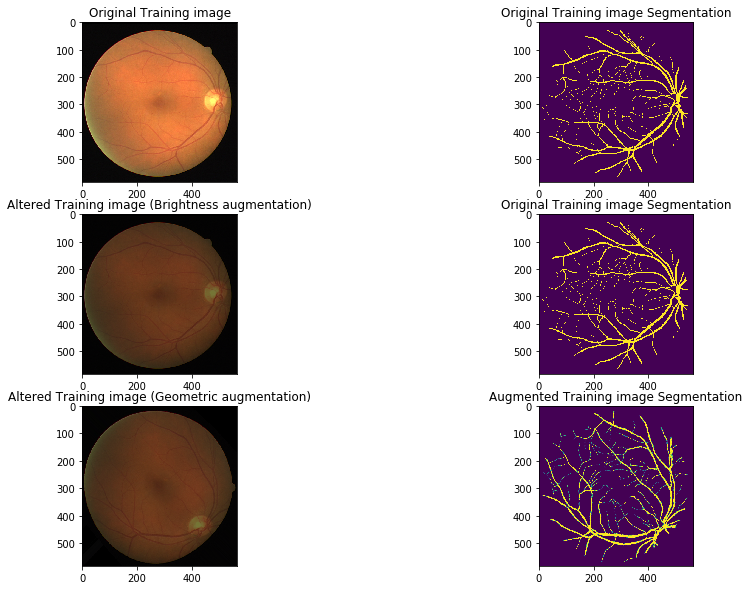

In [5]:
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

#Create training images with an altered brightness
train_image_original=train_images[0]
Altered_brightness_images=change_brightness(train_images)

#Preform b-spline geometric augmentation on the altered training images
gryd_changes=gryds_function(Altered_brightness_images,train_segmentations)
train_images=gryd_changes[0]

# Visualize the results of the alteration of the training image brightness using the first 2 results.
fig, ax = plt.subplots(3,2,figsize=(15, 10))
ax[0,0].imshow(train_image_original)
ax[0,0].set_title("Original Training image")
ax[1,0].imshow(Altered_brightness_images[0])
ax[1,0].set_title("Altered Training image (Brightness augmentation)")
ax[2,0].imshow(gryd_changes[0][0])
ax[2,0].set_title("Altered Training image (Geometric augmentation)")
ax[0,1].imshow(train_segmentations[0][:, :, 0])
ax[0,1].set_title("Original Training image Segmentation")
ax[1,1].imshow(train_segmentations[0][:, :, 0])
ax[1,1].set_title("Original Training image Segmentation")
ax[2,1].imshow(gryd_changes[1][0])
ax[2,1].set_title("Augmented Training image Segmentation")
plt.show()

train_segmentations=gryd_changes[1]
# in order to create the correct matrix dimensions, the matrix needds to be manipulated, otherwise the model will not recognize the augmented segmentation images
train_segmentations=np.expand_dims(train_segmentations,axis=-1)

We will now train the model using the augmented training data. 

In [6]:
%matplotlib inline

patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# saving checkpoints
filepath = "./trained-models/retina_augmented.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
                              callbacks=[early_stopping, checkpoint])

# Saving the model and loss / accuracies
name = 'retina_augmented_losses'
with open('./trained-models/'+name, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/250
50/50 [==============================] - 7s 138ms/step - loss: 0.5208 - acc: 0.4632 - val_loss: 11.5817 - val_acc: 0.0998

Epoch 00001: val_loss improved from inf to 11.58168, saving model to ./trained-models/retina_augmented.h5
Epoch 2/250
50/50 [==============================] - 2s 46ms/step - loss: 0.3513 - acc: 0.5348 - val_loss: 4.4891 - val_acc: 0.6256

Epoch 00002: val_loss improved from 11.58168 to 4.48905, saving model to ./trained-models/retina_augmented.h5
Epoch 3/250
50/50 [==============================] - 2s 45ms/step - loss: 0.2479 - acc: 0.5405 - val_loss: 7.8495 - val_acc: 0.4283

Epoch 00003: val_loss did not improve from 4.48905
Epoch 4/250
50/50 [==============================] - 2s 46ms/step - loss: 0.2046 - acc: 0.5310 - val_loss: 1.2902 - val_acc: 0.6746

Epoch 00004: val_loss improved from 4.48905 to 1.29020, saving model to ./trained-models/retina_augmented.h5
Epoch 5/250
50/50 [==============================] - 2s 45ms/step - loss: 0.1601 - acc: 0.

50/50 [==============================] - 2s 46ms/step - loss: 0.1068 - acc: 0.5441 - val_loss: 1.0102 - val_acc: 0.7650

Epoch 00042: val_loss did not improve from 0.20973
Epoch 43/250
50/50 [==============================] - 2s 45ms/step - loss: 0.1088 - acc: 0.5387 - val_loss: 0.3319 - val_acc: 0.8394

Epoch 00043: val_loss did not improve from 0.20973
Epoch 44/250
50/50 [==============================] - 2s 43ms/step - loss: 0.1052 - acc: 0.5305 - val_loss: 0.3591 - val_acc: 0.8370

Epoch 00044: val_loss did not improve from 0.20973
Epoch 45/250
50/50 [==============================] - 2s 43ms/step - loss: 0.1000 - acc: 0.5425 - val_loss: 0.8956 - val_acc: 0.5821

Epoch 00045: val_loss did not improve from 0.20973
Epoch 46/250
50/50 [==============================] - 2s 44ms/step - loss: 0.0947 - acc: 0.5544 - val_loss: 0.3836 - val_acc: 0.8235

Epoch 00046: val_loss did not improve from 0.20973
Epoch 47/250
50/50 [==============================] - 2s 44ms/step - loss: 0.0963 - acc:

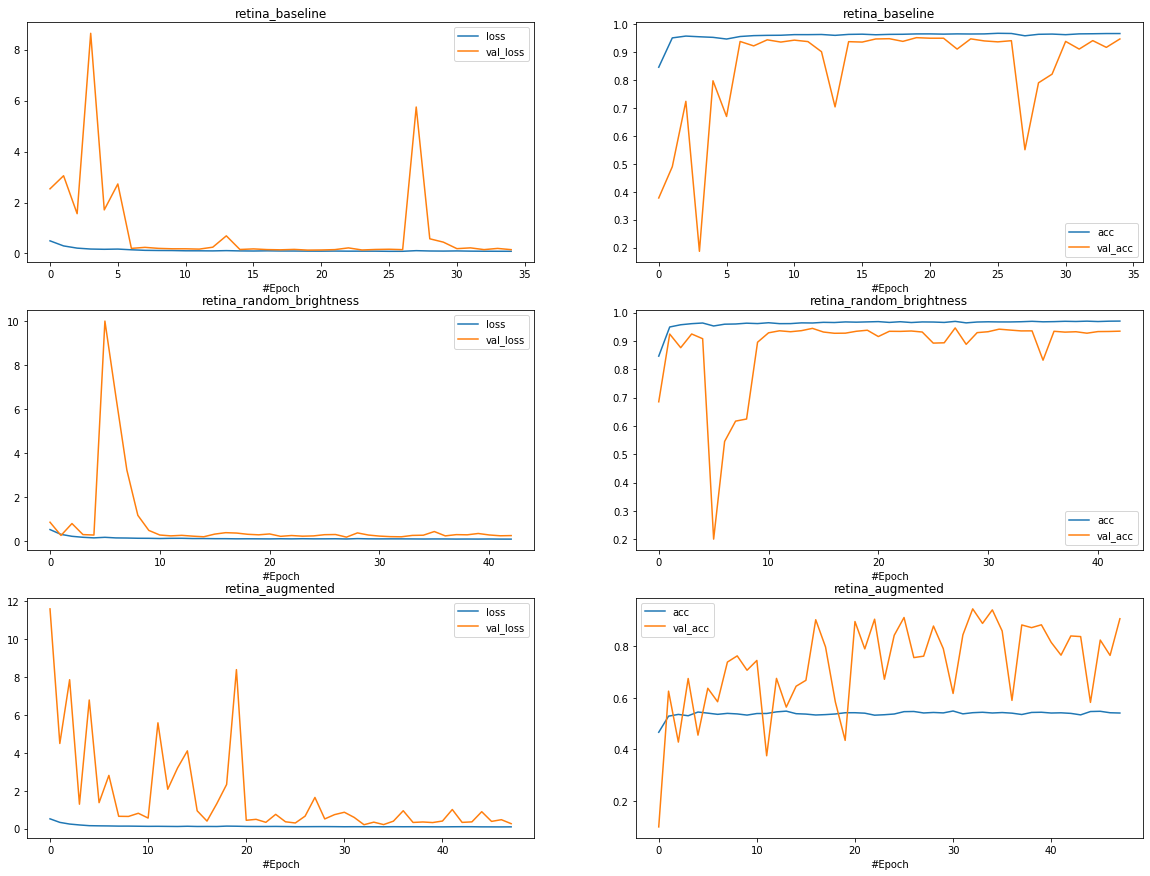

In [7]:
# Plotting losses and accuracies of all retina models

fnames = ['retina_baseline_losses', 'retina_random_brightness_losses', 'retina_augmented_losses']
fig, axes = plt.subplots(3, 2, figsize=(20,15))
axes = axes.flatten()

i = 0
for fn in fnames:
    with open('./trained-models/'+fn, 'rb') as f:
        logs = pickle.load(f)
    axes[i].plot(logs['loss'])
    axes[i].plot(logs['val_loss'])
    axes[i].legend(['loss', 'val_loss'])
    axes[i].set_title(fn[:-7])
    axes[i].set_xlabel("#Epoch")
    
    axes[i+1].plot(logs['acc'])
    axes[i+1].plot(logs['val_acc'])
    axes[i+1].legend(['acc', 'val_acc'])
    axes[i+1].set_title(fn[:-7])
    axes[i+1].set_xlabel("#Epoch")
    i += 2

The application of data augmentation can reduce overfitting because it alters the training data. Data augmentation of the training dataset creates a bigger difference between the validation dataset and the training dataset. The model will only extract features which are not dependent on the intensity, or location because these will be augmented. Therefore it makes a more general estimation of how an image of a retina can look like and is more flexible in handeling different input images. 

The application of data augmentation on a test dataset is possible when you want to examine whether your model would correctly classify the same image before and after augmentation. This will then give an indication, how robust the trained model is. 

When we look at the training data for which only the brightness has been altered, the accuracy on the training set has a relatively high value, which is approximately the same as for the baseline model.

Implementing geometrical augmentation in combination with an altered brightness, it is seen how the training accuracy is lower than for the baseline and random brighntness model. For the augmented model, the validation accuracy is quite constant throughout the training process (as seen in the figures above) and the best values are very similar or marginally lower than for the random brightness model. The baseline model however still shows the highest validation accuracy.

We now load the created models and test them on the a test sample in order to visualize the results of the model.


In [8]:
# run the model on one test image and show the results
from code.unet_utils import preprocessing
from glob import glob
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from code.unet_utils import extract_patches, preprocessing, datagenerator, load_data
from code.unet_model import unet
from code.change_brightness import *
from code.gryds_function import *
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from glob import glob

# load the brightness augmentation and the b-spline + brightness augmentation 
model = load_model("./trained-models/retina_random_brightness.h5")
model_2 = load_model("./trained-models/retina_augmented.h5")

# test data paths
impaths_test = glob('./DRIVE/test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))
# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[2], axis=0), np.expand_dims(test_masks[2], axis=0)

# predict test samples for both models
test_prediction = model.predict(X_test, batch_size=4)
test_prediction_2 = model_2.predict(X_test, batch_size=4)


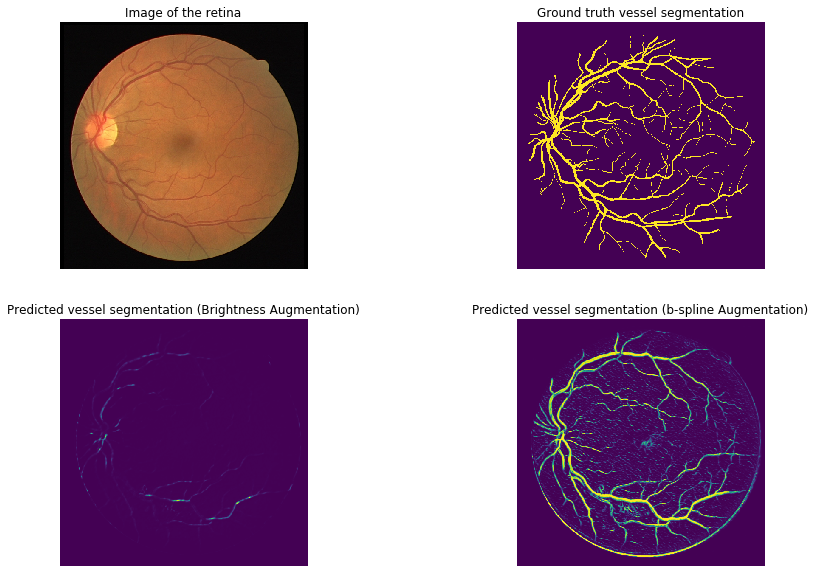

In [9]:
# visualize the test result
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(2, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(2, 2, 3)
plt.title("Predicted vessel segmentation (Brightness Augmentation)")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.subplot(2, 2, 4)
plt.title("Predicted vessel segmentation (b-spline Augmentation)")
plt.axis('off')
plt.imshow(test_prediction_2[0, :, :, 0])

plt.show()

The images above show the segmentation results of a test image using the data augemented trained models. It's clear to see that the results of the model that only used brightness augmented training images, has a clear prediction for the vessels. The segmentation results of the model that used b-spline and brightness augmented training images, are more vague and hard to interpret. 